- *It works!*
- DONE: use `max_batchsize` from `utils`
- DONE: make **dedicated notebook** to (i) compare `conll2003` to `fewnerd` and (ii) to bring `fewnerd` into the same format.
- DONE: use fewnerd
- DONE: get total flops count with **einops**
- DONE: make custom splits
- DONE: reorder the notebook cells:
  - DONE: model (LoRA) and tokenizer (save peftconfig if necessary)
  - DONE: dataset etc
  - DONE: training, metrics and saving (tokenizer and model)
  - DONE: inference via loading saved items (probably tokenizer, model and peftconfig – OR follow this [guide](https://huggingface.co/docs/peft/v0.9.0/en/package_reference/lora#peft.LoraModel))
- DONE: In **Using the fine-tuned model**, [merge and unload](https://huggingface.co/docs/peft/v0.6.2/en/package_reference/tuners#peft.LoraModel.merge_and_unload) or [reinstantiate](https://huggingface.co/docs/peft/v0.6.2/en/task_guides/token-classification-lora#inference) the LoRA model!
- DONE: adjust batch size – and if necessary epochs – for 3000 training steps `num_steps = train_instances*epochs/batch_size` $\geq$ 3000 $\Rightarrow$ `batch_size` $\leq$ `train_instances*epochs/3000 = train_instances/1000` $\Rightarrow$ `batch_size` $\leq$ `train_instances / 1000` for `epochs = 3`<br>DONE: But do it like this:
  - DONE: get max batch size for model (= max_batchsize_by_model)
  - DONE: specify trainig split
  - DONE: get max batch size for training split length (=max_batchsize_by_trainsplit)
  - DONE: impose max batch size of 32
  - DONE: the batch size is the minimum of these three numbers
- DONE: build `results.json` (consider pandas series) via dict. It holds: splits, specified loraconfig details, flops, metrics (per epoch)
- DONE: use the uuid library to save `results.json` under `results_{uuid}.json`
- DONE: declare variable `split` and use it to select splits as well as for logging it in `results_{uuid}.json`.
- DONE: use split `dev` and determine the learning rate for LoRA models. It seems that with `accelerate`, the maximum accepted learning rate is `5e-4` since fails for higher learning rates.
- DONE: outside the training loop make a dummy classification report using scikit-learn with dummy labels and dummy predictions (both formatted as required by classification report)
- DONE: at the end of each epoch, bring the labels and predictions into the required format
- DONE: write a compute metrics function that returns a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) as dict, then log the relevant values
- DONE: drop the `uuid` from the `logs_dict` filename as it only adds ambiguity about what file to look at.
- DONE: Use both `macro` and `weighted` metrics.
- DONE: Specify `output_dir` with `spec` (e.g. `ner_logs/fb-roberta/{spec}`) for saving `logs_dict.json` and `confusion_matrix.png`:
  - DONE: pattern: `task/model/spec/*files_with_vanilla_names*`
  - DONE: example: `ner_logs/FacebookAI-roberta-large/split=dev__r=64__bias=lora_only__loradroput=0point2/logs_dict.json`
- DONE: Add confusion matrix
  - DONE: save percentage version
  - DONE: save vanilla version
- DONE: Save `logs_dict.json` and `confusion_matrix.png`.
- DONE: keep original ner labels (IOB2 would result in 2*n-1 labels instead of n labels – but due to sparse labels, the dataset is already difficult enough)
- DONE: filter out long instances with 80 words or more $\Rightarrow$ remove 0.3384% of training instances (negligible).
- Drop accelerate and use basic torch loop as in `roberta-base-ner_LoRA_cells.ipynb` (make a copy of that other notebook and adapt it to this one.
- Pick a not too long instance from `fewnerd_all_processed` and show token - label pairs (as for inference).
- Handle and log both `roberta-large` and `roberta-base` (adapt `batch_size_dict`).
- Check once more the wandb [ablation study](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU) on batch sizes!
- check everything once more
- add comments
- make new notebook copy for sweep

# NER with `fewnerd` and LoRA

In [1]:
import os
import re
import json
import time
import torch
import datetime
import itertools
import numpy as np

from peft import LoraConfig, TaskType, PeftModel, PeftConfig, get_peft_model, prepare_model_for_kbit_training
from utils import set_seed, make_confusion_matrix
from dotenv import load_dotenv
from datasets import load_dataset, concatenate_datasets, DatasetDict
from evaluate import load
from tqdm.auto import tqdm
from accelerate import Accelerator
from torch.optim import AdamW
from transformers import get_scheduler, pipeline, AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from huggingface_hub import login
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from deepspeed.profiling.flops_profiler import FlopsProfiler

load_dotenv()
login(token=os.getenv("HUGGINGFACE_API_KEY"))
logs_dict = {}
logs_dict["seed"] = set_seed(42)

[2024-03-22 20:04:19,304] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/matthias/.cache/huggingface/token
Login successful
All random seeds set to 42.


## Model

In [2]:
raw_datasets = load_dataset("DFKI-SLT/few-nerd", "supervised")
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names
print(label_names)
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
id2label, label2id

['O', 'art', 'building', 'event', 'location', 'organization', 'other', 'person', 'product']


({'0': 'O',
  '1': 'art',
  '2': 'building',
  '3': 'event',
  '4': 'location',
  '5': 'organization',
  '6': 'other',
  '7': 'person',
  '8': 'product'},
 {'O': '0',
  'art': '1',
  'building': '2',
  'event': '3',
  'location': '4',
  'organization': '5',
  'other': '6',
  'person': '7',
  'product': '8'})

In [3]:
model_version = "base" # "base" or "large"
model_id = f"FacebookAI/roberta-{model_version}" # "FacebookAI/roberta-base" or "FacebookAI/roberta-large"
logs_dict["model_id"] = model_id
model = AutoModelForTokenClassification.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
    load_in_8bit=True
)
# LoRA model
# datasets:      3 values [1%, 10%, 100%]
# lora_rank:    10 values [1, ..., 512]
# lora_dropout:  5 values [0, 0.1, 0.2, 0.3, 0.4]
# lora_bias:     3 values ["all", "none", "lora_only"]
# => 3 x 10 x 5 x 3 = 450 sweeps per notebook (of which 45 have rank 512 and thus take 45*3.75h=168.75 > 168h=7*24h => a bit over two weeks
# => start with 2 dataset values (10%, 100%) and 3 rank values (2, 8, 32) => 6 sweeps
LoRA_params_dict = {
    "r": 512,
    "target_modules": ["query", "key", "value", "query_proj", "key_proj", "value_proj"],
    "bias": "all",
    "use_rslora": True,
    "task_type": TaskType.TOKEN_CLS,
    "lora_dropout": 0.2
}
logs_dict["LoRA_params_dict"] = LoRA_params_dict
# r =   1 => (  156681, 354476050, 0.00044)
# r =   2 => (  304137, 354623506, 0.00086)
# r =   4 => (  599049, 354918418, 0.00169)
# r =   8 => ( 1188873, 355508242, 0.00334)
# r =  16 => ( 2368521, 356687890, 0.00664)
# r =  32 => ( 4727817, 359047186, 0.01317)
# r =  64 => ( 9446409, 363765778, 0.02597)
# r = 128 => (18883593, 373202962, 0.0506)
# r = 256 => (37757961, 392077330, 0.0963)
# r = 512 => (75506697, 429826066, 0.17567)
config = LoraConfig(
    # GUIDE   => https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft
    # https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft:~:text=use_rslora%3A%20When%20set%20to%20True%2C%20uses%20Rank%2DStabilized%20LoRA%20which%20sets%20the%20adapter%20scaling%20factor
    # https://arxiv.org/abs/2312.03732, 
    r = LoRA_params_dict["r"],
    target_modules=LoRA_params_dict["target_modules"],
    bias=LoRA_params_dict["bias"],
    use_rslora=LoRA_params_dict["use_rslora"],
    task_type=LoRA_params_dict["task_type"],
    lora_dropout=LoRA_params_dict["lora_dropout"]
)
logs_dict["LoraConfig"] = str(config)
print(f"LoRA config:\n{config}\n")
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, config)
print(f"base_model type:\n{type(model)}")
print(f"\nadapter_model type:\n{type(model)}")
trainable_params, all_params = model.get_nb_trainable_parameters()
trainable_fraction = round(trainable_params/all_params, 5)
logs_dict["LoRA_model_trainable_params"] = trainable_params
logs_dict["LoRA_model_all_params"] = all_params
logs_dict["LoRA_model_trainable_fraction"] = trainable_fraction
print(f"\ntrainable parameters:\n{trainable_params}")
print(f"\nall parameters:\n{all_params}")
print(f"\ntrainable fraction:\n{trainable_fraction}")

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA config:
LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.TOKEN_CLS: 'TOKEN_CLS'>, inference_mode=False, r=512, target_modules={'query', 'value_proj', 'query_proj', 'key_proj', 'key', 'value'}, lora_alpha=8, lora_dropout=0.2, fan_in_fan_out=False, bias='all', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

base_model type:
<class 'peft.peft_model.PeftModelForTokenClassification'>

adapter_model type:
<class 'peft.peft_model.PeftModelForTokenClassification'>

trainable parameters:
28420617

all parameters:
152380434

trainable fraction:
0.18651


In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_id, add_prefix_space=True)
logs_dict["tokenizer"] = model_id
print(f"tokenizer is fast: {tokenizer.is_fast}")
tokenizer

tokenizer is fast: True


RobertaTokenizerFast(name_or_path='FacebookAI/roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

## Dataset

In [5]:
raw_datasets = load_dataset("DFKI-SLT/few-nerd", "supervised")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 131767
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 18824
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 37648
    })
})

In [6]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

fewnerd_all_processed = (
    concatenate_datasets([raw_datasets["train"], raw_datasets["validation"], raw_datasets["test"]])
    # pre-tokenization, the "tokens" column contains words (not tokens)
    .filter(lambda example: len(example["tokens"])<=30) # 80 (roberta-large) => from 188239 to 187602 (637 instances or 0.3384% removed)
    .map(                                               # 50 (roberta-base) => from 188239 to 181338 (...)
        tokenize_and_align_labels,                      # 30 (roberta-base) => from 188239 to 141195 (...)
        batched=True,
        remove_columns=raw_datasets["train"].column_names
    )
)
fewnerd_all_processed

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 141195
})

In [7]:
# filter dataset by length if necessary
trainvalid_test_splits = fewnerd_all_processed.train_test_split(test_size=0.15)
test_split_100 = trainvalid_test_splits["test"]
test_split_10 = test_split_100.train_test_split(test_size = 0.1)["test"]
test_split_1 = test_split_100.train_test_split(test_size = 0.01)["test"]
trainvalid_split = trainvalid_test_splits["train"]
train_valid_split = trainvalid_split.train_test_split(test_size=0.15)
valid_split_100 = train_valid_split["test"]
valid_split_10 = valid_split_100.train_test_split(test_size = 0.1)["test"]
valid_split_1 = valid_split_100.train_test_split(test_size = 0.01)["test"]
train_split_100 = train_valid_split["train"]
train_split_10 = train_split_100.train_test_split(test_size = 0.1)["test"]
train_split_1 = train_split_100.train_test_split(test_size = 0.01)["test"]
dev_train_split = train_split_100.train_test_split(test_size = 120)["test"]
dev_valid_split = valid_split_100.train_test_split(test_size = 32)["test"]
dev_test_split = test_split_100.train_test_split(test_size = 8)["test"]
fewnerd_dsd = DatasetDict({
    "train_100": train_split_100,
    "train_10": train_split_10,
    "train_1": train_split_1,
    "valid_100": valid_split_100,
    "valid_10": valid_split_10,
    "valid_1": valid_split_1,
    "test_100": test_split_100,
    "test_10": test_split_10,
    "test_1": test_split_1,
    "train_dev": dev_train_split,
    "valid_dev": dev_valid_split,
    "test_dev": dev_test_split
})
fewnerd_dsd

DatasetDict({
    train_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 102012
    })
    train_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10202
    })
    train_1: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1021
    })
    valid_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 18003
    })
    valid_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1801
    })
    valid_1: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 181
    })
    test_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21180
    })
    test_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2118
    })
    test_1: Dataset({
        features: ['input_ids', 'attentio

In [8]:
split = "dev" # "100", "10", "1", "dev"
assert split in ("100", "10", "1", "dev"), f"Split '{split}' is not a valid choice."
train_split = f"train_{split}"
valid_split = f"valid_{split}"
test_split = f"test_{split}"
train_split, valid_split, test_split

('train_dev', 'valid_dev', 'test_dev')

In [9]:
spec = f"split={split}"
spec += f"__r={LoRA_params_dict['r']}"
spec += f"__bias={LoRA_params_dict['bias']}"
spec += f"__loradroput=0point{str(LoRA_params_dict['lora_dropout'])[2:]}"
model_folder = re.sub("/", "-", model_id)
output_dir = f"ner_logs/{model_folder}/{spec}"
output_dir

'ner_logs/FacebookAI-roberta-base/split=dev__r=512__bias=all__loradroput=0point2'

## Training

In [10]:
batchsize_dict = {
    # values have been found manually via trial and error
    # batch size rules: (i) as large as possible, (ii) 1000 steps per epoch, (iii) 32 max
    "base": {
        "100": 1,
        "10": 1,
        "1": 1,
        "dev": 1
    },
    "large": {
        "100": 32, # OK: 32, max: 128
        "10": 8,
        "1": 1,
        "dev": 1
    }
}
batch_size = batchsize_dict[model_version][split]
batch_size

1

In [11]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=RobertaTokenizerFast(name_or_path='FacebookAI/roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple

In [12]:
batch = data_collator([fewnerd_dsd[train_split][i] for i in [2, 3]])
batch["labels"] # As we can see, the second set of labels has been padded to the length of the first one using -100s.

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    7,    8,    8,    7,    8,    7,    8,    8,    0,    0,
            0,    0,    0,    7,    7,    8,    7,    7,    8,    8,    8,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0, -100],
        [-100,    0,    0,    0,    0,    0,    7,    0,    0,    0,    0,    4,
            0,    4,    0,    0,    4,    4,    0,    4,    0,    0,    4,    4,
            4,    0,    4,    0, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100]])

In [13]:
train_dataloader = DataLoader(
    fewnerd_dsd[train_split],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size
)
valid_dataloader = DataLoader(fewnerd_dsd[valid_split], collate_fn=data_collator, batch_size=batch_size)
train_dataloader, valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd5bc18ae60>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd5bc18b700>)

In [14]:
optimizer = AdamW(model.parameters(), lr=5e-4) # 5e-4 works
accelerator = Accelerator()
model, optimizer, train_dataloader, valid_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
    valid_dataloader
)
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch
logs_dict["num_training_steps"] = num_training_steps
num_warmup_steps = min(500, round(0.15 * num_update_steps_per_epoch)) # 500 or 15% of one epoch, whichever is less
logs_dict["num_warmup_steps"] = num_warmup_steps
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)
print(f"training_steps (all epochs):\t{num_training_steps}\nnum_warmup_steps (first epoch):\t{num_warmup_steps}")

training_steps (all epochs):	360
num_warmup_steps (first epoch):	18


In [15]:
def flatten_list_of_lists(list_of_lists):
    flattened_list = []
    for list_i in list_of_lists:
        list_i = list_i.tolist() # handle tensors in case list_of_lists is a list of tensors
        list_i = list(itertools.chain.from_iterable(list_i)) # flatten list_i using the standard library
        flattened_list += list_i
    return flattened_list

def compute_metrics(y_true, y_pred, average_type):
    metrics_dict = classification_report(y_true, y_pred, digits=6, output_dict=True, zero_division=0.0)
    accuracy = metrics_dict["accuracy"]
    avg_dict = metrics_dict[average_type]
    avg_dict["accuracy"] = accuracy
    # https://stackoverflow.com/questions/52139110/how-to-change-the-order-of-keys-in-a-python-3-5-dictionary-using-another-list-a
    avg_dict_order = {k : avg_dict[k] for k in ["accuracy", "precision", "recall", "f1-score", "support"]}
    avg_dict_order["support"] = round(avg_dict_order["support"])
    metrics = [f"{key}: {avg_dict_order[key]}" for key in avg_dict_order.keys()]
    return metrics

prof = FlopsProfiler(model) # deepspeed profiler
flops_list = []
training_start = True
validation_start = True
progress_bar = tqdm(range(num_training_steps))
start_time = time.time() # start time
for epoch in range(num_train_epochs):
    # Training
    model.train()
    prof.start_profile() # start profiling
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        o_step = optimizer.step()
        lr_step = lr_scheduler.step()
        if training_start:
            print("\ntraining")
            print([f"{key} shape: {list(batch[key].shape)}" for key in list(batch.keys())])
            print(f"logits shape: {list(outputs['logits'].shape)}, loss: {float(outputs['loss'])}\n")
            print(f"optimizer step:\t{o_step}")
            print(f"learning rate step:\t{lr_step}")
            training_start = False
        optimizer.zero_grad()
        progress_bar.update(1)
        prof.stop_profile() # stop profiling
    total_flops = prof.get_total_flops()
    flops_list.append(total_flops)
    # Validation
    model.eval()
    epoch_predictions = []
    epoch_labels = []
    for batch in valid_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
        if validation_start:
            print("validation")
            print([f"{key} shape: {list(batch[key].shape)}" for key in list(batch.keys())])
            print(f"logits shape: {list(outputs['logits'].shape)}, loss: {float(outputs['loss'])}\n")
            validation_start = False
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        assert len(predictions)==len(labels)
        epoch_predictions.append(predictions)
        epoch_labels.append(labels)
    # collect both, labels and predictions, in one big list each
    flat_epoch_labels = flatten_list_of_lists(epoch_labels)
    flat_epoch_predictions = flatten_list_of_lists(epoch_predictions)
    # get classification report, then log and print results
    metrics_macro = compute_metrics(flat_epoch_labels, flat_epoch_predictions, "macro avg")
    metrics_weighted = compute_metrics(flat_epoch_labels, flat_epoch_predictions, "weighted avg")
    logs_dict[f"epoch_{epoch}_metrics_macro"] = metrics_macro
    logs_dict[f"epoch_{epoch}_metrics_weighted"] = metrics_weighted
    print(f"\nepoch {epoch}\nmetrics_macro\n{metrics_macro}\nmetrics_weighted\n{metrics_weighted}")
    # save model
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir)
    # save tokenizer
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
#
stop_time = time.time()
training_loop_time = str(datetime.timedelta(seconds = round(stop_time-start_time)))
print(f"training loop time: {training_loop_time}")
logs_dict["training_loop_time"] = training_loop_time
prof.end_profile() # end profiling
logs_dict["flops_list"] = flops_list
print(flops_list)
flops_array = np.array(flops_list)
np.sum(flops_array), np.mean(flops_array)

  0%|          | 0/360 [00:00<?, ?it/s]

[2024-03-22 20:04:27,290] [INFO] [profiler.py:80:start_profile] Flops profiler started


/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



training
['input_ids shape: [1, 35]', 'attention_mask shape: [1, 35]', 'labels shape: [1, 35]']
logits shape: [1, 35, 9], loss: 2.0774192810058594

optimizer step:	None
learning rate step:	None
validation
['input_ids shape: [1, 33]', 'attention_mask shape: [1, 33]', 'labels shape: [1, 33]']
logits shape: [1, 33, 9], loss: 1.3649256229400635


epoch 0
metrics_macro
['accuracy: 0.6836879432624113', 'precision: 0.07596532702915682', 'recall: 0.1111111111111111', 'f1-score: 0.09023682486193017', 'support: 705']
metrics_weighted
['accuracy: 0.6836879432624113', 'precision: 0.4674292037623862', 'recall: 0.6836879432624113', 'f1-score: 0.5552444627674512', 'support: 705']
[2024-03-22 20:04:55,239] [INFO] [profiler.py:80:start_profile] Flops profiler started


/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



epoch 1
metrics_macro
['accuracy: 0.6836879432624113', 'precision: 0.07596532702915682', 'recall: 0.1111111111111111', 'f1-score: 0.09023682486193017', 'support: 705']
metrics_weighted
['accuracy: 0.6836879432624113', 'precision: 0.4674292037623862', 'recall: 0.6836879432624113', 'f1-score: 0.5552444627674512', 'support: 705']
[2024-03-22 20:05:21,062] [INFO] [profiler.py:80:start_profile] Flops profiler started


/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



epoch 2
metrics_macro
['accuracy: 0.6836879432624113', 'precision: 0.07596532702915682', 'recall: 0.1111111111111111', 'f1-score: 0.09023682486193017', 'support: 705']
metrics_weighted
['accuracy: 0.6836879432624113', 'precision: 0.4674292037623862', 'recall: 0.6836879432624113', 'f1-score: 0.5552444627674512', 'support: 705']
training loop time: 0:01:20
[2024-03-22 20:05:47,079] [INFO] [profiler.py:226:end_profile] Flops profiler finished
[4096730400, 3718422528, 1145600640]


(8960753568, 2986917856.0)

In [26]:
optimizer.step()

In [16]:
model.train
output = model(**batch)
output

/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


TokenClassifierOutput(loss=tensor(0.9873, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[[ 2.9176, -1.5849, -1.1255, -2.4578, -0.1181, -0.4775, -0.3526,
          -0.1572, -0.1662],
         [ 2.9149, -1.5889, -1.1255, -2.4510, -0.1191, -0.4808, -0.3586,
          -0.1538, -0.1561],
         [ 2.9159, -1.5919, -1.1250, -2.4526, -0.1163, -0.4775, -0.3503,
          -0.1558, -0.1570],
         [ 2.9117, -1.5815, -1.1220, -2.4520, -0.1152, -0.4765, -0.3542,
          -0.1519, -0.1585],
         [ 2.9066, -1.5870, -1.1250, -2.4482, -0.1127, -0.4769, -0.3546,
          -0.1527, -0.1582],
         [ 2.9107, -1.5844, -1.1256, -2.4555, -0.1154, -0.4760, -0.3567,
          -0.1550, -0.1565],
         [ 2.9137, -1.5851, -1.1245, -2.4531, -0.1203, -0.4753, -0.3515,
          -0.1540, -0.1595],
         [ 2.9105, -1.5856, -1.1283, -2.4574, -0.1171, -0.4814, -0.3521,
          -0.1546, -0.1585],
         [ 2.9094, -1.5829, -1.1259, -2.4442, -0.1198, -0.4768, -0.3502,
          -0.158

In [17]:
float(output.loss) # loss, logits

0.9873404502868652

In [18]:
batch["labels"] # input_ids, labels

tensor([[-100,    0,    8,    8,    8,    8,    8,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0, -100]],
       device='cuda:0')

/home/matthias/Desktop/Compute-Optimal_LoRA-Adapters_for_Language_Models/utils.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  conf_matrix[i] *= 100/np.sum(conf_matrix[i])
/home/matthias/Desktop/Compute-Optimal_LoRA-Adapters_for_Language_Models/utils.py:62: RuntimeWarning: invalid value encountered in multiply
  conf_matrix[i] *= 100/np.sum(conf_matrix[i])


confusion_matrix saved under path:
ner_logs/FacebookAI-roberta-base/split=dev__r=512__bias=all__loradroput=0point2/confusion_matrix_pct.png
confusion_matrix saved under path:
ner_logs/FacebookAI-roberta-base/split=dev__r=512__bias=all__loradroput=0point2/confusion_matrix_abs.png


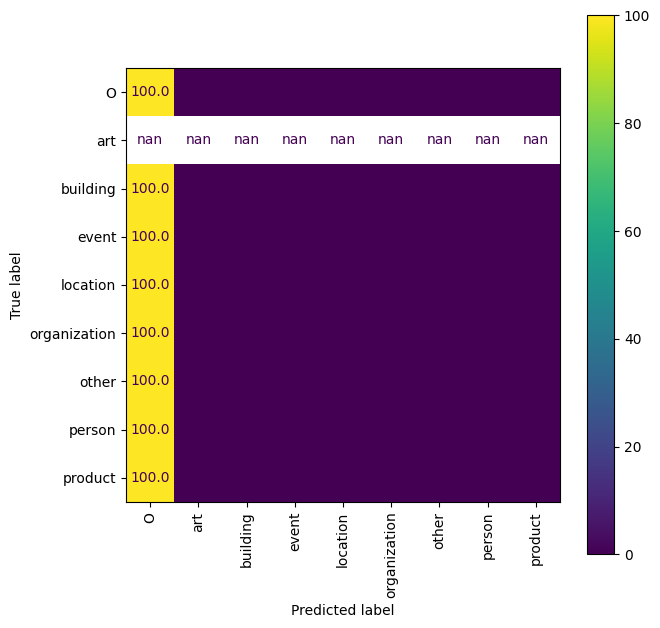

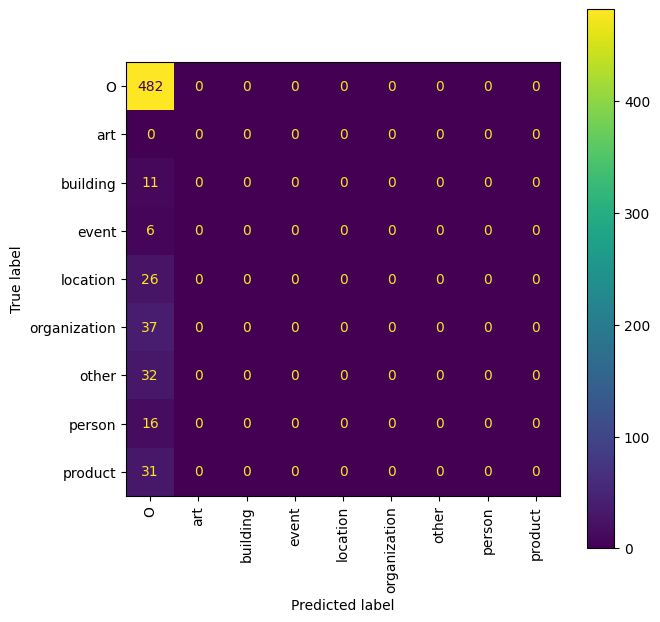

In [19]:
flat_epoch_labels_without_special_tokens = []
flat_epoch_predictions_without_special_tokens = []
for i in range(len(flat_epoch_labels)):
    label_i = flat_epoch_labels[i]
    prediction_i = flat_epoch_predictions[i]
    if label_i!=-100:
        flat_epoch_labels_without_special_tokens.append(label_i)
        flat_epoch_predictions_without_special_tokens.append(prediction_i)
# plot and save confusion matrices
for percentage in [True, False]:
    make_confusion_matrix(
        flat_epoch_labels_without_special_tokens,
        flat_epoch_predictions_without_special_tokens,
        label_names,
        percentage=percentage,
        output_dir=output_dir
    )

## Save logs and reload model for inference

In [20]:
with open(f"{output_dir}/logs_dict.json", "w") as outfile: 
	json.dump(logs_dict, outfile, indent=2)
logs_dict

{'seed': 42,
 'model_id': 'FacebookAI/roberta-base',
 'LoRA_params_dict': {'r': 512,
  'target_modules': ['query',
   'key',
   'value',
   'query_proj',
   'key_proj',
   'value_proj'],
  'bias': 'all',
  'use_rslora': True,
  'task_type': <TaskType.TOKEN_CLS: 'TOKEN_CLS'>,
  'lora_dropout': 0.2},
 'LoraConfig': "LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.TOKEN_CLS: 'TOKEN_CLS'>, inference_mode=False, r=512, target_modules={'query', 'value_proj', 'query_proj', 'key_proj', 'key', 'value'}, lora_alpha=8, lora_dropout=0.2, fan_in_fan_out=False, bias='all', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})",
 'LoRA_model_trainable_params': 28420617,
 'LoRA_model_all_params': 152380434,
 'LoRA_model_trainable_fraction': 0.18651,
 'tokenizer':

In [21]:
# load inference model
config = PeftConfig.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)
inference_model = AutoModelForTokenClassification.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
    load_in_8bit=True
)
inference_model = PeftModel.from_pretrained(inference_model, output_dir).merge_and_unload()
print(f"type(inference_model):\n{type(inference_model)}\n")
# get inputs from text (source: https://en.wikipedia.org/wiki/Konstanz#History)
text = "Konstanz was the birthplace of Count Ferdinand von Zeppelin, constructor of the famous Zeppelin airships."
inputs = tokenizer(text, return_tensors="pt")
inputs

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


type(inference_model):
<class 'transformers.models.roberta.modeling_roberta.RobertaForTokenClassification'>



/home/matthias/.local/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:71: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


{'input_ids': tensor([[    0, 11272, 22398,   329,    21,     5, 32357,     9, 12440, 28855,
          5689, 10915, 38042,     6, 47073,     9,     5,  3395, 10915, 38042,
           935, 31404,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [22]:
# inference
with torch.no_grad():
    logits = inference_model(**inputs).logits
tokens = inputs.tokens()
predictions = torch.argmax(logits, dim=2)
print(f"token (prediction)\n")
for token, prediction in zip(tokens, predictions[0].numpy()):
    print(f"{token} ({id2label[str(prediction)]})")

token (prediction)

<s> (O)
ĠKon (O)
stan (O)
z (O)
Ġwas (O)
Ġthe (O)
Ġbirthplace (O)
Ġof (O)
ĠCount (O)
ĠFerdinand (O)
Ġvon (O)
ĠZe (O)
ppelin (O)
, (O)
Ġconstructor (O)
Ġof (O)
Ġthe (O)
Ġfamous (O)
ĠZe (O)
ppelin (O)
Ġair (O)
ships (O)
. (O)
</s> (O)


$\checkmark$